In [1]:
from glob import glob
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import pandas as pd
from scipy.sparse import csr_array
from functools import reduce

import config
import sys
sys.path.append("../")

from sklearn.metrics import ndcg_score
from detect import detect_singlebatch, detect_multibatch, _get_altered_in_window
from utils import get_support_bucket


In [2]:
exp_type = "adult"
if exp_type == "adult":
    noise = 0.5
    checkpoint = "xgb-adult"
    ckpt_dir = "/data2/fgiobergia/drift-experiments/"
else:
    ckpt_dir = os.path.join(config.ckpt_dir, "sup-wise")
    noise = 1.0
    checkpoint = "resnet50"
# fnames = glob(os.path.join(ckpt_dir, f"{checkpoint}-noise-{noise:.2f}*pkl"))
# supports = [ get_support_bucket(fname) for fname in fnames ]

# df_names = pd.DataFrame({ "filename": fnames, "from_sup": [a for a,b in supports], "to_sup": [b for a,b in supports] })

In [3]:
from distill import Result

with open(f"{checkpoint}-results-v2.pkl", "rb") as f:
    results = pickle.load(f)

In [4]:
data = []
sup_thresh = {
    "adult": 1.,
    "celeba": 0.5, # for celeba we do not take cases w/ support > 0.5 since only very few subgroups can be analyzed
}[exp_type]

for r in results:
    # 
    if r.metric != "accuracy" or r.gt == "neg" or r.support[0] > sup_thresh:
        continue
    d = {
        "support": r.support[0],
        "window": r.window,
        "result": r
    }
    data.append(d)

df_results = pd.DataFrame(data=data)

In [5]:
# results_subset = df_results.groupby(["support", "window"]).sample(n=10).result.tolist()
n_samples = 50
results_subset = df_results.groupby(["support", "window"]).apply(lambda gb: gb.sample(n=min(len(gb), n_samples))).result.tolist()

In [6]:
GT = {}
tstats = {}
deltas = {}
windows = set()
for r in results_subset:
    if r.gt != "pos" or r.metric != "accuracy":
        continue
    if r.window not in GT: # assume that , if not in GT, also not in tstats and deltas
        GT[r.window] = []
        tstats[r.window] = []
        deltas[r.window] = []
    GT[r.window].append(r.altered)
    tstats[r.window].append(r.tstat)
    deltas[r.window].append(r.delta)
    windows.add(r.window)
windows = sorted(list(windows))

In [7]:
GT = np.stack([ np.vstack(GT[w]) for w in windows ])
tstats = np.stack([ np.vstack(tstats[w]) for w in windows ])
deltas = np.stack([ np.vstack(deltas[w]) for w in windows ])
GT.shape

(9, 871, 192099)

NameError: name 'y_single_delta' is not defined

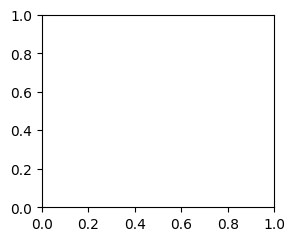

In [8]:
fig, ax = plt.subplots(figsize=(3,2.5))

# y_single_delta = [ ndcg_score(GT[pos], -deltas[pos]) for pos, win in enumerate(windows) ]
# y_single_tstat = [ ndcg_score(GT[pos], tstats[pos]) for pos, win in enumerate(windows) ]
# y_random = [ ndcg_score(GT[pos], np.random.random(GT[pos].shape)) for pos, _ in enumerate(windows) ]

ax.plot(windows, y_single_delta, label="$\Delta_{acc}$", marker='d', c="tab:green")
ax.plot(windows, y_single_tstat, label="$t$", marker='o', c="tab:red")

# show random guess line
ax.plot(windows, y_random, label="Random", ls='--', color='k', alpha=.75)

ax.set_xlabel("Window size [batches]")
ax.set_ylabel("nDCG")
# shift legend slightly down
ax.legend(loc='center right', bbox_to_anchor=(1,0.4))
# 3 columns
# fig.legend(loc='upper center', ncol=3)
ax.grid()
ax.set_ylim([0.875, 1.0])

fig.savefig(f"winsize-ndcg-{exp_type}.pdf", bbox_inches="tight")

# Fixed window size, change support

In [20]:
GT = {}
tstats = {}
deltas = {}
win_size = 5
supports = set()
for r in results_subset:
    if r.gt != "pos" or r.metric != "accuracy" or r.window != win_size:
        continue
    if r.support not in GT: # assume that , if not in GT, also not in tstats and deltas
        GT[r.support] = []
        tstats[r.support] = []
        deltas[r.support] = []
    GT[r.support].append(r.altered)
    tstats[r.support].append(r.tstat)
    deltas[r.support].append(r.delta)
    supports.add(r.support)
supports = sorted(list(supports))

In [21]:
GT = [ np.vstack(GT[sup]) for sup in supports ]
tstats = [ np.vstack(tstats[sup]) for sup in supports ]
deltas = [ np.vstack(deltas[sup]) for sup in supports ]
len(GT), GT[0].shape

(19, (50, 192099))

In [22]:
from scipy.stats import spearmanr, pearsonr

In [23]:
pearson_corr_delta = []
pearson_corr_tstat = []

spearman_corr_delta = []
spearman_corr_tstat = []

for i in range(len(GT)):
    pcd = ((((GT[i] - GT[i].mean(axis=1, keepdims=True)) * (deltas[i] - deltas[i].mean(axis=1, keepdims=True))).mean(axis=1)) / (GT[i].std(axis=1) * deltas[i].std(axis=1)))
    pct = ((((GT[i] - GT[i].mean(axis=1, keepdims=True)) * (tstats[i] - tstats[i].mean(axis=1, keepdims=True))).mean(axis=1)) / (GT[i].std(axis=1) * tstats[i].std(axis=1)))

    pearson_corr_delta.append((pcd.mean(), pcd.std()))
    pearson_corr_tstat.append((pct.mean(), pct.std()))

    c = spearmanr(GT[i], deltas[i], axis=1).statistic
    scd = np.diagonal(c, offset=GT[i].shape[0]) if not isinstance(c, float) else c

    c = spearmanr(GT[i], tstats[i], axis=1).statistic
    sct = np.diagonal(c, offset=GT[i].shape[0]) if not isinstance(c, float) else c

    spearman_corr_delta.append((scd.mean(), scd.std()))
    spearman_corr_tstat.append((sct.mean(), sct.std()))

In [24]:
from sklearn.metrics._ranking import _ndcg_sample_scores
y_tstat = []
y_delta = []
y_rand = []
k = None
for i, sup in enumerate(supports):
    scores = _ndcg_sample_scores(GT[i], tstats[i], k=k)
    y_tstat.append((scores.mean(), scores.std()))
    scores = _ndcg_sample_scores(GT[i], -deltas[i], k=k)
    y_delta.append((scores.mean(), scores.std()))
    scores = _ndcg_sample_scores(GT[i], np.random.random(GT[i].shape), k=k)
    y_rand.append((scores.mean(), scores.std()))

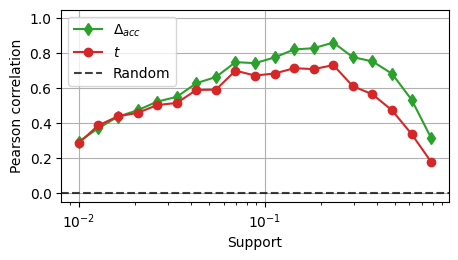

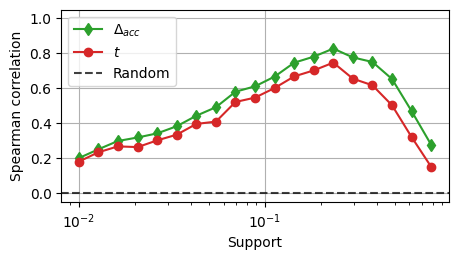

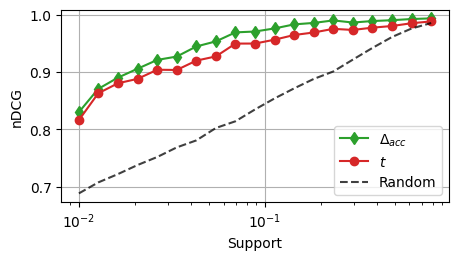

In [25]:
# plt.errorbar([ b[0] for b in supports ], [ -c[0] for c in corr_delta], label="delta")
# plt.errorbar([ b[0] for b in supports ], [ c[0] for c in corr_tstat], label="t-stat")
# plt.xscale("log")

fig0, ax0 = plt.subplots(figsize=(5,2.5))
fig1, ax1 = plt.subplots(figsize=(5,2.5))
fig2, ax2 = plt.subplots(figsize=(5,2.5))

errorbar = False

if errorbar:
    ax0.errorbar([ b[0] for b in supports ], [ -c[0] for c in pearson_corr_delta], yerr=[ [ c[1] for c in pearson_corr_delta], [ c[1] if -c[0]+c[1]<1 else 1+c[0] for c in pearson_corr_delta] ], label="delta", capsize=3, c="tab:green", marker="d")
    ax0.errorbar([ b[0] for b in supports ], [ c[0] for c in pearson_corr_tstat],  yerr=[ [ c[1] for c in pearson_corr_tstat], [ c[1] if c[0]+c[1]<1 else 1-c[0] for c in pearson_corr_tstat] ], label="t-stat", capsize=3, c="tab:red", marker="o")
else:
    ax0.plot([ b[0] for b in supports ], [ -c[0] for c in pearson_corr_delta], label=r"$\Delta_{acc}$", marker='d', c="tab:green")
    ax0.plot([ b[0] for b in supports ], [ c[0] for c in pearson_corr_tstat],  label="$t$",            marker='o', c="tab:red")
ax0.axhline(0, color='k', ls='--', alpha=.75, label="Random")
ax0.set_xscale("log")
ax0.grid()
ax0.set_xlabel("Support")
ax0.set_ylabel("Pearson correlation")
ax0.set_ylim([-0.05,1.05])
ax0.legend()


if errorbar:
    ax1.errorbar([ b[0] for b in supports ], [ -c[0] for c in spearman_corr_delta], yerr=[ [ c[1] for c in spearman_corr_delta], [ c[1] if -c[0]+c[1]<1 else 1+c[0] for c in spearman_corr_delta] ], capsize=3, c="tab:green", marker="d")
    ax1.errorbar([ b[0] for b in supports ], [ c[0] for c in spearman_corr_tstat], yerr= [ [ c[1] for c in spearman_corr_tstat], [ c[1] if c[0]+c[1]<1 else 1-c[0] for c in spearman_corr_tstat] ], capsize=3, c="tab:red", marker="o")
else:
    ax1.plot([ b[0] for b in supports ], [ -c[0] for c in spearman_corr_delta], label=r"$\Delta_{acc}$", marker='d', c="tab:green")
    ax1.plot([ b[0] for b in supports ], [ c[0] for c in spearman_corr_tstat],  label="$t$",          marker='o', c="tab:red")
ax1.axhline(0, color='k', ls='--', alpha=.75, label="Random")
ax1.set_xscale("log")
ax1.grid()
ax1.set_xlabel("Support")
ax1.set_ylabel("Spearman correlation")
ax1.set_ylim([-0.05,1.05])
ax1.legend()

# fig, ax = plt.subplots(figsize=(4,2))
ax2.plot([ b[0] for b in supports], [ a for a,b in y_delta], label=r"$\Delta_{acc}$", marker='d', color='tab:green')
ax2.plot([ b[0] for b in supports], [ a for a,b in y_tstat], label="$t$",            marker='o', color='tab:red')
ax2.plot([ b[0] for b in supports], [ a for a,b in y_rand], label="Random", ls='--', color='k', alpha=.75)
ax2.set_xscale("log")
ax2.grid()
ax2.set_ylabel("nDCG")
ax2.set_xlabel("Support")
ax2.legend()

for fig, metric in zip([fig0, fig1, fig2], "pearson spearman ndcg".split()):
    fig.savefig(f"{metric}-vs-sup-{exp_type}.pdf", bbox_inches="tight")
# fig.legend(loc="upper center", ncol=3)
# ax.set_xlabel("Support")

# fig.savefig(f"ranking-sup-{exp_type}.pdf", bbox_inches="tight")

# fig.savefig(f"corr-sup-{exp_type}.pdf", bbox_inches="tight")

In [66]:
def closest_odd(n):
    return 2 * int(n / 2) + 1

start_noise = 0
n_batches = 20
blurs = [None] * start_noise + [
    GaussianBlur(closest_odd(i), sigma=i) if i > 0 else lambda x : x # identity if sigma=0
    for i in np.linspace(1, 25, n_batches - start_noise)
]


In [67]:
from torchvision.datasets import CelebA

ds = CelebA(root="data", split="train", target_type="attr", download=True)

Files already downloaded and verified


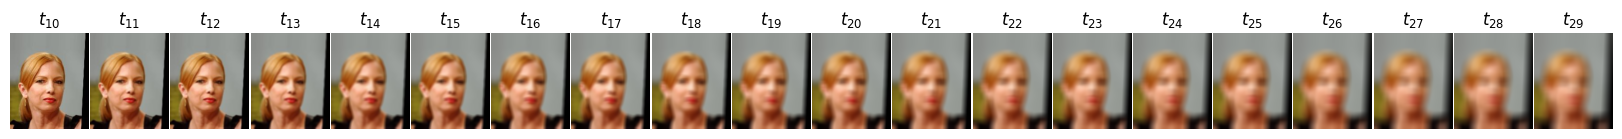

In [75]:
fig, ax = plt.subplots(1, n_batches, figsize=(20.7, 1.25))
for i in range(len(blurs)):
    ax[i].imshow(blurs[i](ds[8000][0]))
    ax[i].axis("off")
    ax[i].set_title(f"$t_{{{i+10}}}$")
# reduce white space between subplots
fig.subplots_adjust(wspace=0, hspace=0)
fig.savefig("noise.pdf", bbox_inches="tight")

In [5]:
cnt = 0
skip = 5
for window in range(2, 11):
    start_w = skip
    end_w = window+skip

    for start_w2 in range(end_w, 30 - window):
        end_w2 = start_w2 + window
        cnt += 1
        # print(start_w, end_w, start_w2, end_w2)
        if (start_w, end_w, start_w2, end_w2) == (5, 14, 20, 29):
            print(cnt)
print(cnt)

112
117


In [70]:
for div in divs:
    div["accuracy"] = (div["tp"] + div["tn"]) / (div["tp"] + div["tn"] + div["fp"] + div["fn"])

In [79]:
from functools import reduce

reduce(lambda a,b: a+b, [ div["accuracy"] for div in divs[:10] ]) / 10

subgroup
(23)               0.777845
(19)               0.785655
(2)                0.775466
(16)               0.965632
(38)               0.758428
                     ...   
(5, 21, 6)         0.915582
(5, 19, 21, 6)     0.915582
(19, 20, 21)       0.890952
(20, 21, 6)        0.910612
(19, 20, 21, 6)    0.910612
Name: accuracy, Length: 26597, dtype: float64

In [3]:
import pickle
import numpy as np

with open("output-experiments-skip-0-topn-200-run2.pkl", "rb") as f:
    results = pickle.load(f)

In [4]:
max_win_size = None
max_delay = None

topn = 200

for start_ref_win, end_ref_win, start_curr_win, end_curr_win in results:
    assert end_ref_win - start_ref_win == end_curr_win - start_curr_win

    window = end_ref_win - start_ref_win
    delay = start_curr_win - end_ref_win

    if max_win_size is None or max_delay is None:
        max_win_size = window
        max_delay = delay
    
    max_win_size = max(max_win_size, window)
    max_delay = max(max_delay, delay)

key = list(results.keys())[0]
sg_pos = np.array([ (matches.fi.itemsets == i).values.nonzero()[0][0] for i in results[key][0]["sgs"] ])

# mat_tstat = np.full((max_win_size+1, max_delay+1), np.nan)
# mat_delta = np.full((max_win_size+1, max_delay+1), np.nan)
mat_tstat = np.full((max_win_size+1, 30), np.nan)
mat_delta = np.full((max_win_size+1, 30), np.nan)

for key in results:
    start_ref_win, end_ref_win, start_curr_win, end_curr_win = key
    window = end_ref_win - start_ref_win
    delay = start_curr_win - end_ref_win

    crop_topn_tstat = results[key][0]["tstats"].argsort(axis=1)[:, -topn:]
    crop_topn_delta = results[key][0]["deltas"].argsort(axis=1)[:, :topn]
    found = (crop_topn_tstat == sg_pos.reshape(-1,1)).any(axis=1)
    mat_tstat[window, delay+window*2-1] = found.mean()

    found = (crop_topn_delta == sg_pos.reshape(-1,1)).any(axis=1)
    mat_delta[window, delay+window*2-1] = found.mean()

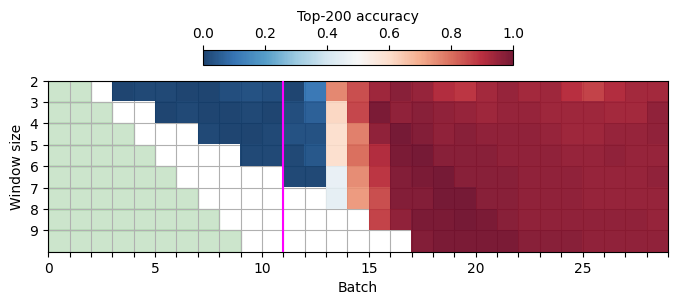

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
# include legend for colors
m = ax.imshow(mat_tstat, vmin=0, vmax=1, zorder=2, extent=[0, 30, max_win_size+1, 0], cmap='RdBu_r', alpha=.9)
ax.set_xticks(range(30))
ax.set_yticks(range(max_win_size+1))
# shift all ticks 0.5 right
ax.set_xticklabels([ str(i) if i % 5 == 0 else "" for i in range(30) ])



for ws in range(2, max_win_size+1):
    # draw rectangle of size win_size on the left
    # black borders
    ax.add_patch(plt.Rectangle((0, ws), ws, 1, color='g', alpha=.2, zorder=1))


ax.set_xlabel("Batch")
ax.set_ylabel("Window size")
ax.grid()
ax.axvline(11, c='#f0f', zorder=3)
ax.set_xlim([0, 30-1])
ax.set_ylim([max_win_size+1, 2])
fig.colorbar(m, shrink=0.5, orientation="horizontal",  ax=ax, label=f"Top-{topn} accuracy", location="top")
fig.savefig("ttest-corr.pdf", bbox_inches="tight")

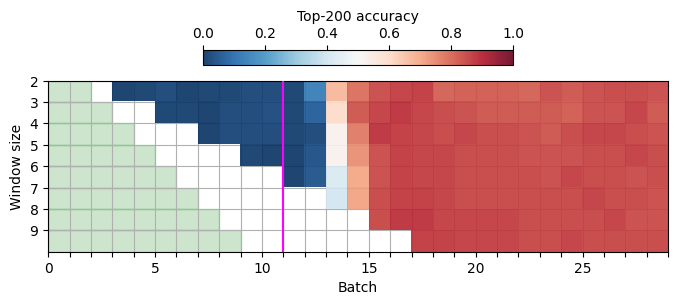

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
# include legend for colors
m = ax.imshow(mat_delta, vmin=0, vmax=1, zorder=2, extent=[0, 30, max_win_size+1, 0], cmap='RdBu_r', alpha=.9)
ax.set_xticks(range(30))
ax.set_yticks(range(max_win_size+1))
# shift all ticks 0.5 right
ax.set_xticklabels([ str(i) if i % 5 == 0 else "" for i in range(30) ])



for ws in range(2, max_win_size+1):
    # draw rectangle of size win_size on the left
    # black borders
    ax.add_patch(plt.Rectangle((0, ws), ws, 1, color='g', alpha=.2, zorder=1))


ax.set_xlabel("Batch")
ax.set_ylabel("Window size")
ax.grid()
ax.axvline(11, c='#f0f', zorder=3)
ax.set_xlim([0, 30-1])
ax.set_ylim([max_win_size+1, 2])
fig.colorbar(m, shrink=0.5, orientation="horizontal",  ax=ax, label=f"Top-{topn} accuracy", location="top")
fig.savefig("delta-corr.pdf", bbox_inches="tight")

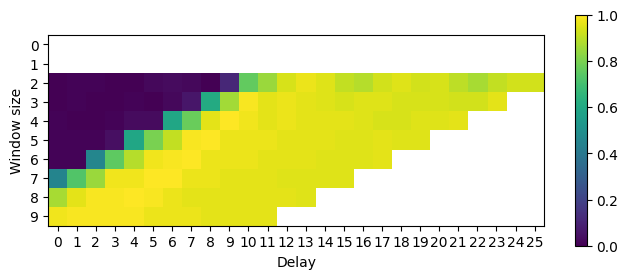

In [11]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 4))
# include legend for colors
m = ax.imshow(mat, cmap='viridis', vmin=0, vmax=1)
ax.set_xticks(range(max_delay+1))
ax.set_yticks(range(max_win_size+1))
ax.set_xlabel("Delay")
ax.set_ylabel("Window size")
# make the colorbar shorter
fig.colorbar(m, shrink=0.75)
# fig.colorbar(m) # 200


In [12]:
mat

array([[ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
         nan,  nan,  nan,  nan],
       [0.  , 0.01, 0.01, 0.  , 0.  , 0.02, 0.03, 0.02, 0.  , 0.11, 0.76,
        0.85, 0.94, 0.97, 0.95, 0.91, 0.89, 0.93, 0.95, 0.93, 0.94, 0.9 ,
        0.87, 0.91, 0.93, 0.93],
       [0.  , 0.01, 0.  , 0.  , 0.01, 0.  , 0.02, 0.06, 0.61, 0.86, 0.99,
        0.96, 0.97, 0.96, 0.95, 0.94, 0.95, 0.95, 0.94, 0.94, 0.94, 0.93,
        0.93, 0.96,  nan,  nan],
       [0.01, 0.  , 0.  , 0.01, 0.03, 0.03, 0.59, 0.77, 0.96, 1.  , 0.98,
        0.96, 0.97, 0.96, 0.96, 0.96, 0.95, 0.94, 0.94, 0.95, 0.95, 0.96,
         nan,  nan,  nan,  nan],
       [0.01, 0.01, 0.01, 0.04, 0.59, 0.8 , 0.91, 0.99, 1.  , 0.97, 0.97,
        0.97, 0.96, 0

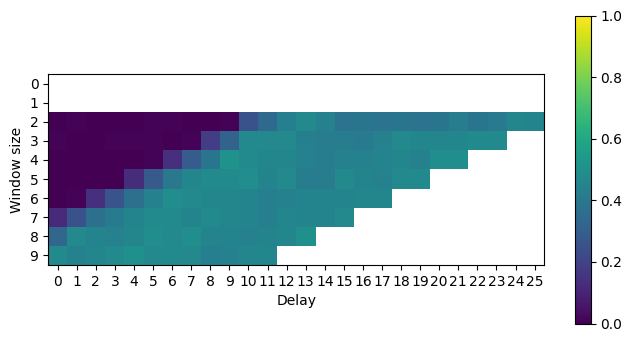

In [204]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(8, 4))
# include legend for colors
m = ax.imshow(mat, cmap='viridis', vmin=0, vmax=1)
ax.set_xticks(range(max_delay+1))
ax.set_yticks(range(max_win_size+1))
ax.set_xlabel("Delay")
ax.set_ylabel("Window size")
fig.colorbar(m) # 25


In [94]:
max_win_size = None
max_delay = None

topn = 200

for start_ref_win, end_ref_win, start_curr_win, end_curr_win in results:
    assert end_ref_win - start_ref_win == end_curr_win - start_curr_win

    window = end_ref_win - start_ref_win
    delay = start_curr_win - end_ref_win

    if max_win_size is None or max_delay is None:
        max_win_size = window
        max_delay = delay
    
    max_win_size = max(max_win_size, window)
    max_delay = max(max_delay, delay)

mat = np.full((max_win_size+1, max_delay+1), np.nan)
for key in results:
    start_ref_win, end_ref_win, start_curr_win, end_curr_win = key
    window = end_ref_win - start_ref_win
    delay = start_curr_win - end_ref_win

    mat[window, delay] = results[key][0]["ranks"].mean()

In [100]:
matches.matches.shape

(101300, 26597)

In [30]:
tgt = '/home/fgiobergia/div-mitigation/models-ckpt/sup-wise/resnet50-noise-1.00-support-0.0695-0.0886-target-32-35-5-38.pkl'
with open(tgt, "rb") as f:
    obj = pickle.load(f)

In [31]:
obj.keys()

dict_keys(['subgroup', 'batches', 'accuracies', 'f1', 'divs', 'y_trues', 'y_preds', 'blurs', 'altered', 'matches_batches'])

In [39]:
obj["matches_batches"][0].fi

,support,itemsets
0,0.835341,(23)
1,0.415637,(19)
2,0.203968,(2)
3,0.042231,(16)
4,0.772902,(38)
...,...,...
26592,0.010128,"(5, 21, 6)"
26593,0.010109,"(5, 19, 21, 6)"
26594,0.014482,"(19, 20, 21)"
26595,0.011352,"(20, 21, 6)"


In [41]:
obj["matches_batches"][0].fi[obj["matches_batches"][0].fi.itemsets == frozenset([32, 35, 5, 38])]

,support,itemsets
3422,0.074719,"(32, 35, 5, 38)"


In [42]:
for div in obj["matches_batches"]:
    print(div.matches[:, [3422]].mean())

0.0722534794196032
0.07551080840983121
0.0728457210541901
0.07936037903464613
0.07462244595795084
0.07639917086171158
0.07106899615042936
0.07728753331359195
0.07758365413088539
0.07787977494817885
0.07254960023689666
0.06603494225644063
0.08054486230381995
0.07314184187148356
0.07373408350607047
0.07699141249629848
0.07758365413088539
0.07639917086171158
0.07314184187148356
0.07553317535545023
0.07345971563981044
0.07701421800947869
0.07138625592417062
0.0743483412322275
0.0699052132701422
0.07286729857819907
0.07731042654028436
0.07790284360189574
0.06516587677725119
0.0764218009478673
